# Framingham Heart Disease Risk Study
 ## Modeling

In [8]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report, \
                            roc_auc_score, roc_curve, auc,\
                            confusion_matrix, ConfusionMatrixDisplay, \
                            accuracy_score, \
                            precision_recall_curve, \
                            mean_absolute_error, mean_squared_error, r2_score, \
                            f1_score, precision_score, recall_score, make_scorer


from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, ElasticNet, SGDClassifier, SGDRegressor, LassoCV, RidgeCV, ElasticNetCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from functions.grid_plots import annotate

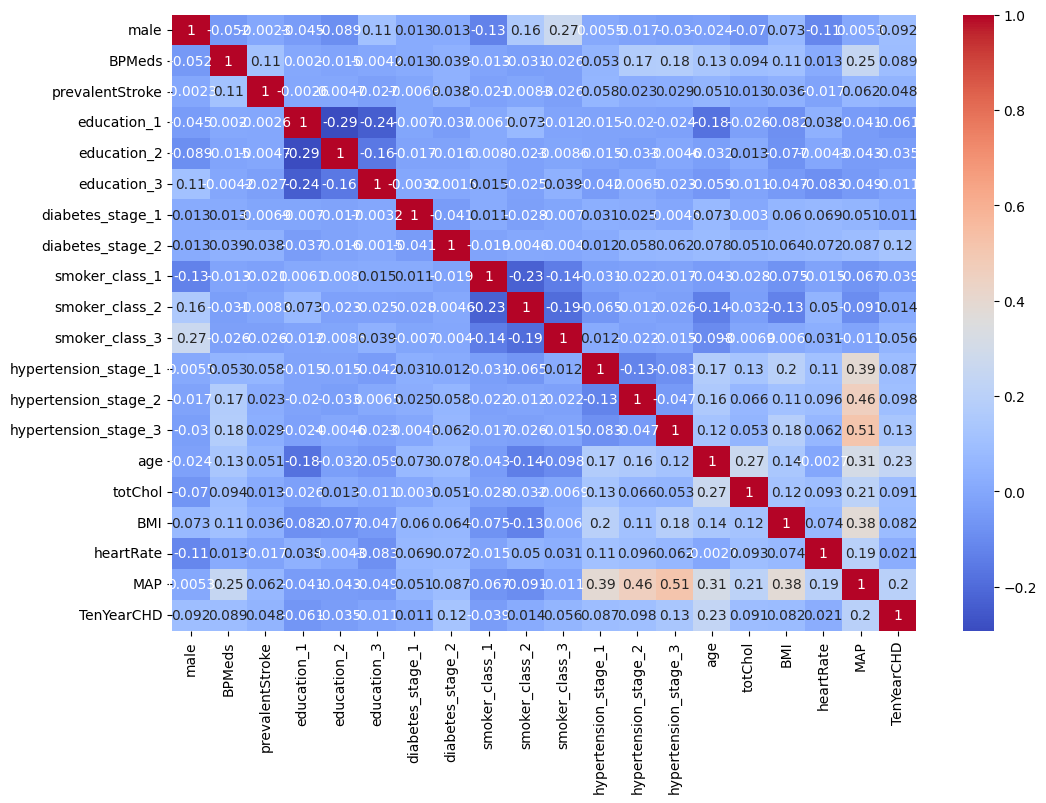

In [2]:
# Review the correlation matrix of the dataset
df = pd.read_csv('../data/processed/df_dummy_scaled.csv')
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm');

In [3]:
# Load the data
X_train_path = "../data/processed/X_train.csv"
X_test_path = "../data/processed/X_test.csv"
y_train_path = "../data/processed/y_train.csv"
y_test_path = "../data/processed/y_test.csv"

X_train, X_test, y_train, y_test = pd.read_csv(X_train_path), pd.read_csv(X_test_path), pd.read_csv(y_train_path), pd.read_csv(y_test_path)

In [4]:
# Store the column/feature names
feature_names = X_train.columns

# Convert the data to numpy arrays
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values.flatten()
y_test = y_test.values.flatten()

In [12]:
# Create a function to evaluate the model
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, fit=True, grid_search=False, annotation=None):
    """
    This function evaluates the model using the training and testing data.
    It calculates the accuracy, precision, recall, F1 score, ROC AUC, and plots the ROC curve.
    """
    # Fit the model
    if fit:
        model.fit(X_train, y_train)
    else:
        model = model
    
    if grid_search:
        print(f"Best Parameters for {model_name} Model:\n"
            f"{model.best_params_}\n\n"
            f"Best Estimator for {model_name} Model:\n"
            f"{model.best_estimator_}\n")
        model = model.best_estimator_
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate the accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    # Calculate the precision
    train_precision = precision_score(y_train, y_train_pred)
    test_precision = precision_score(y_test, y_test_pred)
    
    # Calculate the recall
    train_recall = recall_score(y_train, y_train_pred)
    test_recall = recall_score(y_test, y_test_pred)
    
    # Calculate the F1 score
    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    
    # Calculate the ROC AUC
    train_roc_auc = roc_auc_score(y_train, y_train_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    
    # Get the feature importances
    plot_importance = True
    try:
        if hasattr(model, 'feature_importances_'):
            feature_importances = model.feature_importances_
        else:
            feature_importances = model.coef_
        
        # print(feature_importances)
        feature_imp_df = pd.DataFrame(feature_importances)
        feature_imp_df.columns = feature_names
        feature_imp_df = feature_imp_df.T
        feature_imp_df.columns = ['Importance']
        feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)
        feature_imp_df = feature_imp_df.T
    
    except Exception as e:
        feature_importances = None
        plot_importance = False
    
    
    # Print the results
    print(f"Results for {model_name} Model:")
    print("Training Accuracy: {:.4f}".format(train_accuracy))
    print("Testing Accuracy: {:.4f}".format(test_accuracy))
    print()
    print("Training Precision: {:.4f}".format(train_precision))
    print("Testing Precision: {:.4f}".format(test_precision))
    print()
    print("Training Recall: {:.4f}".format(train_recall))
    print("Testing Recall: {:.4f}".format(test_recall))
    print()
    print("Training F1 Score: {:.4f}".format(train_f1))
    print("Testing F1 Score: {:.4f}".format(test_f1))
    print()
    print("Training ROC AUC: {:.4f}".format(train_roc_auc))
    print("Testing ROC AUC: {:.4f}".format(test_roc_auc))
    
    
    # Plot the ROC curve
    plt.figure(figsize=(5, 5))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC for {model_name} Model')
    plt.legend(loc="lower right")
    annotate(annotation)
    plt.show()
    
    # Print the classification report
    print(f"Classification Report for {model_name} Model:")
    print(classification_report(y_test, y_test_pred))
    
    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    ConfusionMatrixDisplay(cm, display_labels=model.classes_).plot(values_format='d')
    annotate(annotation);
    
    if plot_importance:
        # Display the feature importance
        plt.figure(figsize=(10, 5))
        sns.barplot(feature_imp_df)
        plt.xticks(rotation=90)
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.title(f'Feature Importance for {model_name} Model')
        # annotate(annotation)
        plt.show()


    # Store the results in the dictionary
    results[model_name] = {'Train Accuracy': train_accuracy,
                            'Test Accuracy': test_accuracy,
                            'Train Precision': train_precision,
                            'Test Precision': test_precision,
                            'Train Recall': train_recall,
                            'Test Recall': test_recall,
                            'Train F1 Score': train_f1,
                            'Test F1 Score': test_f1,
                            'Train ROC AUC': train_roc_auc,
                            'Test ROC AUC': test_roc_auc,
                            "Model": model}
    
    return model
    


# Create a dictionary to store the results
results = {}


Logistic Regression model

In [6]:
# Linear Regression
log_reg = LogisticRegression()

Results for Logistic Regression Model:
Training Accuracy: 0.8553
Testing Accuracy: 0.8347

Training Precision: 0.6071
Testing Precision: 0.5333

Training Recall: 0.0782
Testing Recall: 0.0656

Training F1 Score: 0.1385
Testing F1 Score: 0.1168

Training ROC AUC: 0.5347
Testing ROC AUC: 0.5270


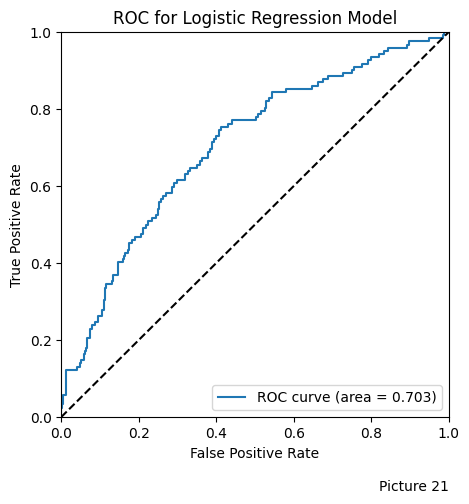

Classification Report for Logistic Regression Model:
              precision    recall  f1-score   support

           0       0.84      0.99      0.91       610
           1       0.53      0.07      0.12       122

    accuracy                           0.83       732
   macro avg       0.69      0.53      0.51       732
weighted avg       0.79      0.83      0.78       732



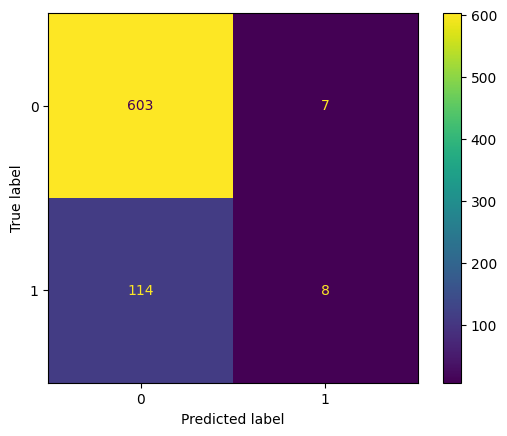

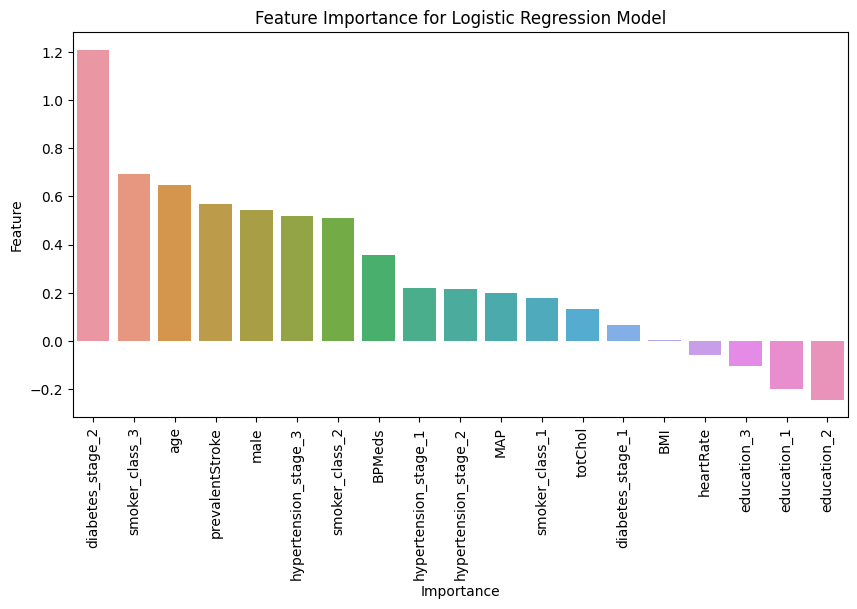

LogisticRegression()

In [11]:
# Fit and evaluate the model
evaluate_model(log_reg, X_train, X_test, y_train, y_test, 'Logistic Regression', annotation='Picture 21')

Naive Bayes

In [9]:
# Naive Bayes
nb = GaussianNB()

Best Parameters for Naive Bayes Model:
{'var_smoothing': 0.0062505519252739694}

Best Estimator for Naive Bayes Model:
GaussianNB(var_smoothing=0.0062505519252739694)

Results for Naive Bayes Model:
Training Accuracy: 0.8170
Testing Accuracy: 0.7923

Training Precision: 0.3555
Testing Precision: 0.3529

Training Recall: 0.2828
Testing Recall: 0.2951

Training F1 Score: 0.3150
Testing F1 Score: 0.3214

Training ROC AUC: 0.5966
Testing ROC AUC: 0.5934


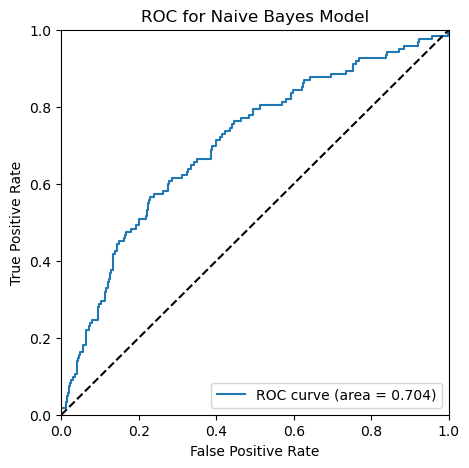

Classification Report for Naive Bayes Model:
              precision    recall  f1-score   support

           0       0.86      0.89      0.88       610
           1       0.35      0.30      0.32       122

    accuracy                           0.79       732
   macro avg       0.61      0.59      0.60       732
weighted avg       0.78      0.79      0.78       732



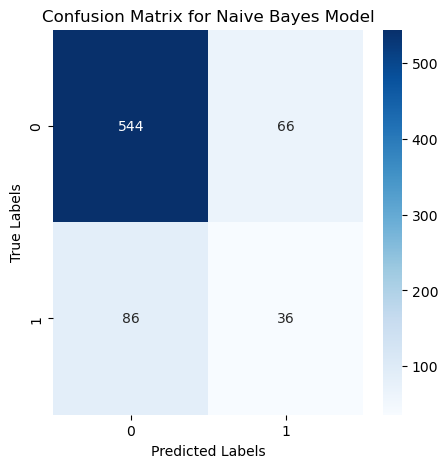

GaussianNB(var_smoothing=0.0062505519252739694)

In [10]:
# Define hyperparameters and scoring metric for GridSearchCV
param_grid = {'var_smoothing': np.logspace(0,-9, num=50)}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
scorer = make_scorer(recall_score, average='binary')

nb_grid = GridSearchCV(nb, param_grid, scoring=scorer, cv=cv, n_jobs=-1)

# Fit and evaluate the model
evaluate_model(nb_grid, X_train, X_test, y_train, y_test, 'Naive Bayes', grid_search=True)

In [11]:
# Print the results
print(f"Best params:\n{nb_grid.best_params_}\n")
print(f"Best score:\n{nb_grid.best_score_}\n")

Best params:
{'var_smoothing': 0.0062505519252739694}

Best score:
0.2781609195402298



KNN

In [12]:
# Fit KNN model with different k values
knn_train_recall = []
knn_test_recall = []
k_values = range(1, 51)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_train_pred = knn.predict(X_train)
    y_test_pred = knn.predict(X_test)
    knn_train_recall.append(recall_score(y_train, y_train_pred))
    knn_test_recall.append(recall_score(y_test, y_test_pred))

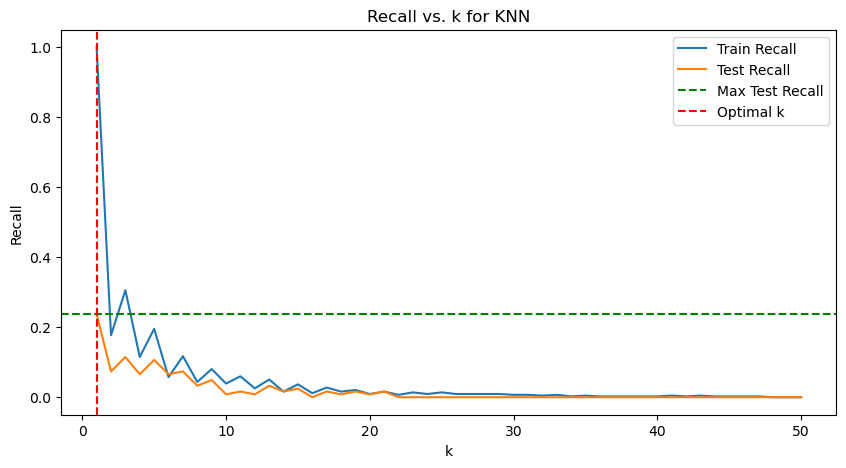

Optimal k value: 1


In [13]:
# Plot the recall scores
k_optimal = knn_test_recall.index(max(knn_test_recall)) + 1

plt.figure(figsize=(10, 5))
plt.plot(k_values, knn_train_recall, label='Train Recall')
plt.plot(k_values, knn_test_recall, label='Test Recall')
plt.axhline(max(knn_test_recall), color='green', linestyle='--', label='Max Test Recall')
plt.axvline(k_optimal, color='red', linestyle='--', label='Optimal k')
plt.xlabel('k')
plt.ylabel('Recall')
plt.title('Recall vs. k for KNN')
plt.legend()
plt.show()

print(f"Optimal k value: {k_optimal}")

Results for K-Nearest Neighbors Best Params Model:
Training Accuracy: 1.0000
Testing Accuracy: 0.7719

Training Precision: 1.0000
Testing Precision: 0.2816

Training Recall: 1.0000
Testing Recall: 0.2377

Training F1 Score: 1.0000
Testing F1 Score: 0.2578

Training ROC AUC: 1.0000
Testing ROC AUC: 0.5582


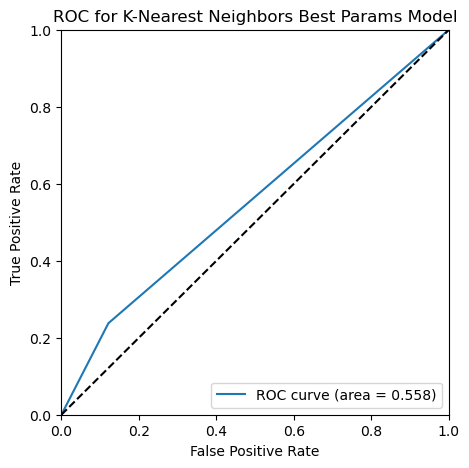

Classification Report for K-Nearest Neighbors Best Params Model:
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       610
           1       0.28      0.24      0.26       122

    accuracy                           0.77       732
   macro avg       0.57      0.56      0.56       732
weighted avg       0.76      0.77      0.76       732



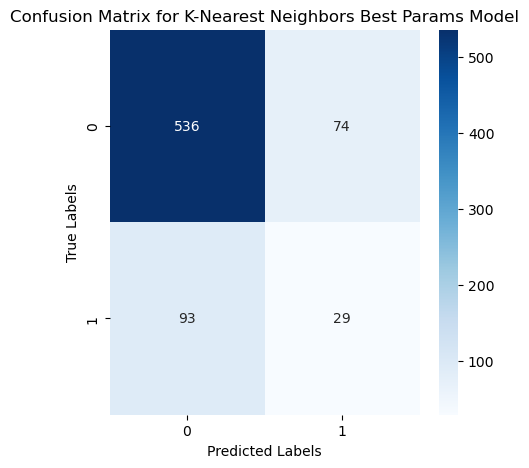

KNeighborsClassifier(n_neighbors=1)

In [14]:
# Fit the KNN model with the optimal k value
knn = KNeighborsClassifier(n_neighbors=k_optimal)

# Fit and evaluate the model
evaluate_model(knn, X_train, X_test, y_train, y_test, 'K-Nearest Neighbors Best Params')

Results for K-Nearest Neighbors Model:
Training Accuracy: 0.8694
Testing Accuracy: 0.8306

Training Precision: 0.7265
Testing Precision: 0.4643

Training Recall: 0.1954
Testing Recall: 0.1066

Training F1 Score: 0.3080
Testing F1 Score: 0.1733

Training ROC AUC: 0.5913
Testing ROC AUC: 0.5410


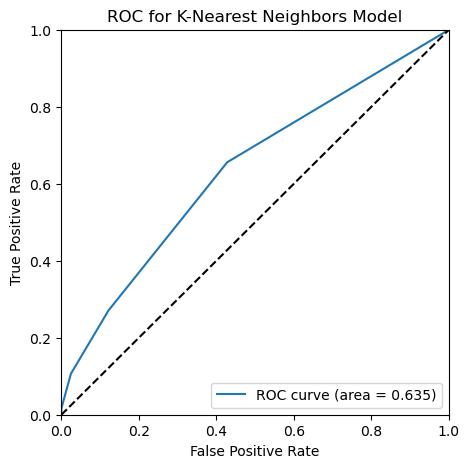

Classification Report for K-Nearest Neighbors Model:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       610
           1       0.46      0.11      0.17       122

    accuracy                           0.83       732
   macro avg       0.65      0.54      0.54       732
weighted avg       0.78      0.83      0.78       732



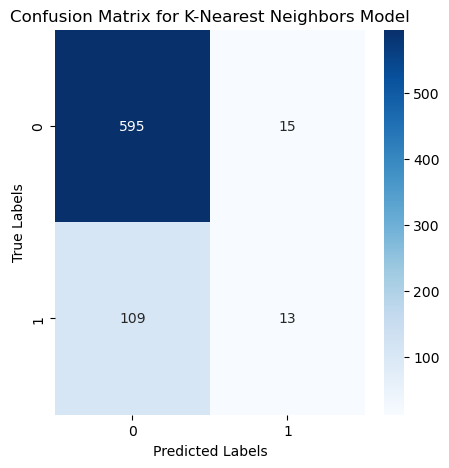

KNeighborsClassifier()

In [15]:
# KNN with default parameters
knn = KNeighborsClassifier()
# Fit and evaluate the model
evaluate_model(knn, X_train, X_test, y_train, y_test, 'K-Nearest Neighbors')

Support Vector Machine

In [16]:
# Support Vector Machine random search
param_distributions = {'C': np.logspace(-3, 2, 6),
                        'gamma': np.logspace(-3, 2, 6),
                        # 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
                        }
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
scorer = make_scorer(recall_score, average='binary')

svm = SVC()
svm_random = RandomizedSearchCV(svm, param_distributions, n_iter=60, scoring=scorer, cv=cv, n_jobs=-1, random_state=42)

# Fit and evaluate the model
svm_random.fit(X_train, y_train)

# Print the results
print(f"Best params:\n{svm_random.best_params_}\n")
print(f"Best score:\n{svm_random.best_score_}\n")

/opt/anaconda3/envs/conda311/lib/python3.11/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 36 is smaller than n_iter=60. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best params:
{'gamma': 0.1, 'C': 100.0}

Best score:
0.1808429118773946



Results for SVM Best Params Model:
Training Accuracy: 0.9395
Testing Accuracy: 0.7964

Training Precision: 0.9924
Testing Precision: 0.3099

Training Recall: 0.5977
Testing Recall: 0.1803

Training F1 Score: 0.7461
Testing F1 Score: 0.2280

Training ROC AUC: 0.7984
Testing ROC AUC: 0.5500


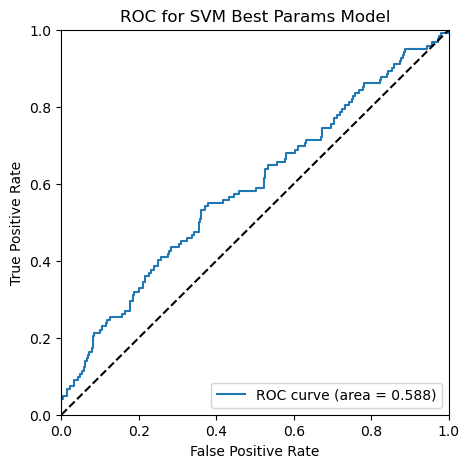

Classification Report for SVM Best Params Model:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       610
           1       0.31      0.18      0.23       122

    accuracy                           0.80       732
   macro avg       0.58      0.55      0.56       732
weighted avg       0.76      0.80      0.77       732



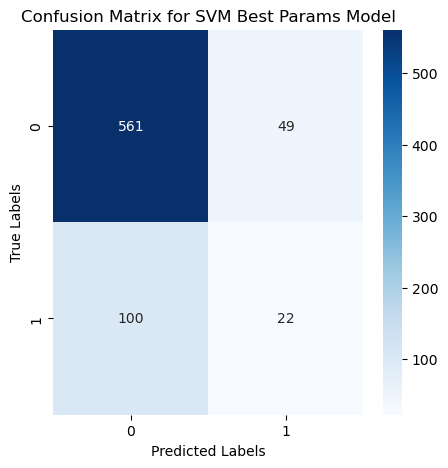

SVC(C=100, gamma=0.1, probability=True)

In [17]:
# Fit and evaluate the model with the best parameters
svm = SVC(C=100, gamma=0.1, probability=True)
evaluate_model(svm, X_train, X_test, y_train, y_test, 'SVM Best Params', grid_search=False)

Results for Support Vector Machine Model:
Training Accuracy: 0.8547
Testing Accuracy: 0.8333

Training Precision: 0.8571
Testing Precision: 0.5000

Training Recall: 0.0276
Testing Recall: 0.0082

Training F1 Score: 0.0535
Testing F1 Score: 0.0161

Training ROC AUC: 0.5134
Testing ROC AUC: 0.5033


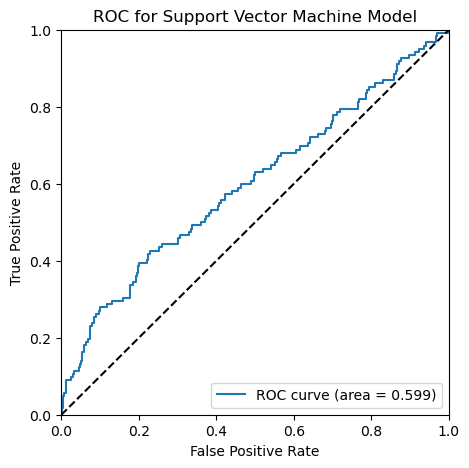

Classification Report for Support Vector Machine Model:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       610
           1       0.50      0.01      0.02       122

    accuracy                           0.83       732
   macro avg       0.67      0.50      0.46       732
weighted avg       0.78      0.83      0.76       732



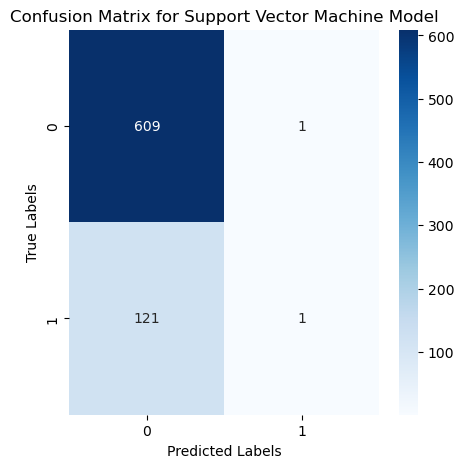

SVC(probability=True, random_state=42)

In [18]:
# Support Vector Machine
svm = SVC(probability=True, random_state=42)

# Fit and evaluate the model
evaluate_model(svm, X_train, X_test, y_train, y_test, 'Support Vector Machine')

Random Forest

In [19]:
# Random Forest random search
param_distributions = {'n_estimators': [100, 200, 300, 400, 500],
                        'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                        'min_samples_split': [2, 5, 10],
                        'min_samples_leaf': [1, 2, 4],
                        'bootstrap': [True, False]}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
scorer = make_scorer(recall_score, average='binary')

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(rf, param_distributions, n_iter=100, scoring=scorer, cv=cv, n_jobs=-1, random_state=42)

# Fit and evaluate the model
import tqdm
with tqdm.tqdm(total=100) as pbar:
    def update_pbar(pbar):
        pbar.update(1)
        return

    rf_random.fit(X_train, y_train)
    update_pbar(pbar)
# rf_random.fit(X_train, y_train)

# Print the results
print(f"Best params:\n{rf_random.best_params_}\n")
print(f"Best score:\n{rf_random.best_score_}\n")

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [01:52<3:05:13, 112.26s/it]

Best params:
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 90, 'bootstrap': False}

Best score:
0.09348659003831415



Results for Random Forest Model:
Training Accuracy: 1.0000
Testing Accuracy: 0.8320

Training Precision: 1.0000
Testing Precision: 0.4545

Training Recall: 1.0000
Testing Recall: 0.0410

Training F1 Score: 1.0000
Testing F1 Score: 0.0752

Training ROC AUC: 1.0000
Testing ROC AUC: 0.5156


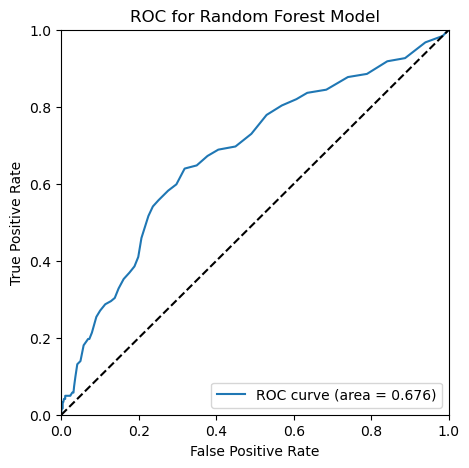

Classification Report for Random Forest Model:
              precision    recall  f1-score   support

           0       0.84      0.99      0.91       610
           1       0.45      0.04      0.08       122

    accuracy                           0.83       732
   macro avg       0.65      0.52      0.49       732
weighted avg       0.77      0.83      0.77       732



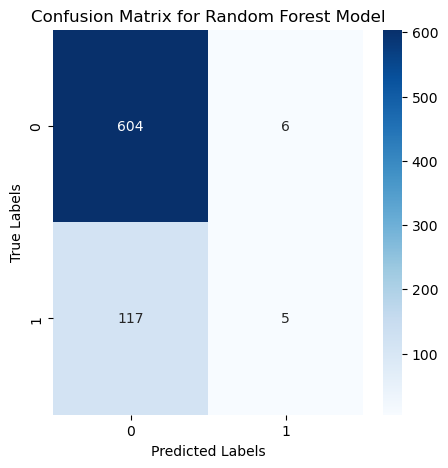

RandomForestClassifier()

In [20]:
# Random Forest with default parameters
rf = RandomForestClassifier()

# Fit and evaluate the model
evaluate_model(rf, X_train, X_test, y_train, y_test, 'Random Forest')


In [21]:
print(f"Best params:\n{rf_random.best_params_}\n")

Best params:
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 90, 'bootstrap': False}



Results for Random Forest Best Params Model:
Training Accuracy: 1.0000
Testing Accuracy: 0.8238

Training Precision: 1.0000
Testing Precision: 0.3158

Training Recall: 1.0000
Testing Recall: 0.0492

Training F1 Score: 1.0000
Testing F1 Score: 0.0851

Training ROC AUC: 1.0000
Testing ROC AUC: 0.5139


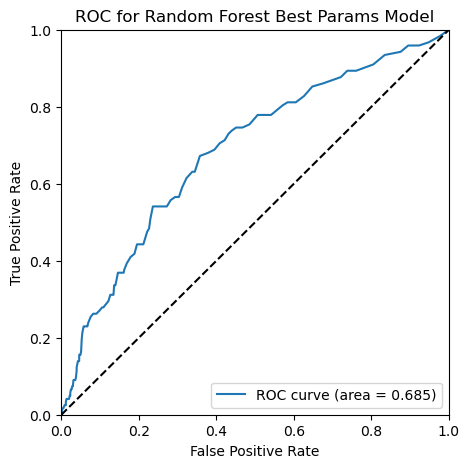

Classification Report for Random Forest Best Params Model:
              precision    recall  f1-score   support

           0       0.84      0.98      0.90       610
           1       0.32      0.05      0.09       122

    accuracy                           0.82       732
   macro avg       0.58      0.51      0.49       732
weighted avg       0.75      0.82      0.77       732



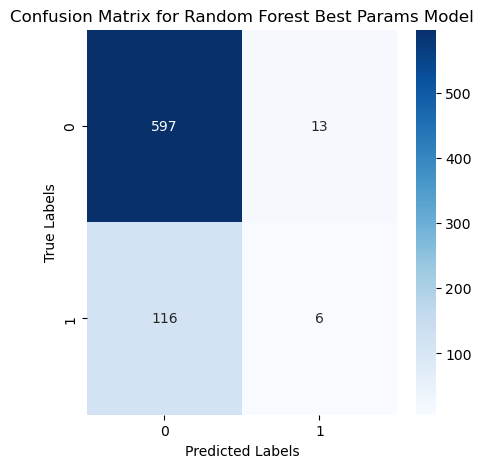

RandomForestClassifier(bootstrap=False, max_depth=60, n_estimators=200)

In [22]:
# Random Forest with the best parameters
rf = RandomForestClassifier(n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_depth=60, bootstrap=False)
# Fit and evaluate the model
evaluate_model(rf, X_train, X_test, y_train, y_test, 'Random Forest Best Params', grid_search=False)

Results for Gradient Boosting Model:
Training Accuracy: 0.8834
Testing Accuracy: 0.8320

Training Precision: 0.9896
Testing Precision: 0.4737

Training Recall: 0.2184
Testing Recall: 0.0738

Training F1 Score: 0.3578
Testing F1 Score: 0.1277

Training ROC AUC: 0.6090
Testing ROC AUC: 0.5287


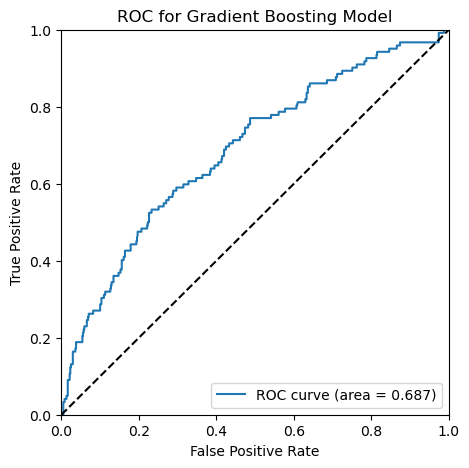

Classification Report for Gradient Boosting Model:
              precision    recall  f1-score   support

           0       0.84      0.98      0.91       610
           1       0.47      0.07      0.13       122

    accuracy                           0.83       732
   macro avg       0.66      0.53      0.52       732
weighted avg       0.78      0.83      0.78       732



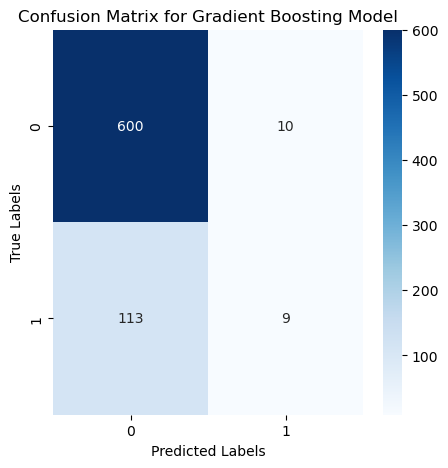

GradientBoostingClassifier()

In [23]:
# Gradient Boosting
gb = GradientBoostingClassifier()

# Fit and evaluate the model
evaluate_model(gb, X_train, X_test, y_train, y_test, 'Gradient Boosting')

Results for XGBoost Model:
Training Accuracy: 0.9901
Testing Accuracy: 0.8128

Training Precision: 1.0000
Testing Precision: 0.3171

Training Recall: 0.9333
Testing Recall: 0.1066

Training F1 Score: 0.9655
Testing F1 Score: 0.1595

Training ROC AUC: 0.9667
Testing ROC AUC: 0.5303


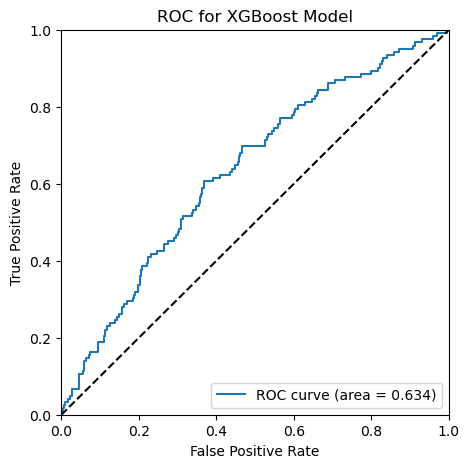

Classification Report for XGBoost Model:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       610
           1       0.32      0.11      0.16       122

    accuracy                           0.81       732
   macro avg       0.58      0.53      0.53       732
weighted avg       0.75      0.81      0.77       732



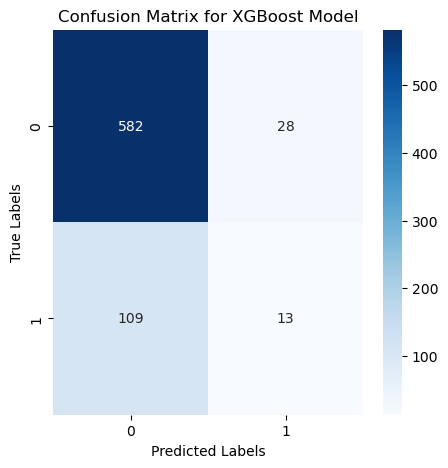

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [24]:
# XGBoost
xgb = XGBClassifier()

# Fit and evaluate the model
evaluate_model(xgb, X_train, X_test, y_train, y_test, 'XGBoost')

In [25]:
# Display the results
results_df = pd.DataFrame(results).T
results_df

,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1 Score,Test F1 Score,Train ROC AUC,Test ROC AUC,Model
Logistic Regression,0.855335,0.834699,0.607143,0.533333,0.078161,0.065574,0.138493,0.116788,0.534661,0.527049,LogisticRegression()
Naive Bayes,0.817031,0.79235,0.355491,0.352941,0.282759,0.295082,0.314981,0.321429,0.596582,0.593443,GaussianNB(var_smoothing=0.0062505519252739694)
K-Nearest Neighbors Best Params,1.0,0.771858,1.0,0.281553,1.0,0.237705,1.0,0.257778,1.0,0.558197,KNeighborsClassifier(n_neighbors=1)
K-Nearest Neighbors,0.869357,0.830601,0.726496,0.464286,0.195402,0.106557,0.307971,0.173333,0.591273,0.540984,KNeighborsClassifier()
SVM Best Params,0.939466,0.796448,0.992366,0.309859,0.597701,0.180328,0.746055,0.227979,0.798449,0.55,"SVC(C=100, gamma=0.1, probability=True)"
Support Vector Machine,0.854651,0.833333,0.857143,0.5,0.027586,0.008197,0.053452,0.016129,0.513391,0.503279,"SVC(probability=True, random_state=42)"
Random Forest,1.0,0.831967,1.0,0.454545,1.0,0.040984,1.0,0.075188,1.0,0.515574,"(DecisionTreeClassifier(max_features='sqrt', r..."
Random Forest Best Params,1.0,0.82377,1.0,0.315789,1.0,0.04918,1.0,0.085106,1.0,0.513934,"(DecisionTreeClassifier(max_depth=60, max_feat..."
Gradient Boosting,0.883379,0.831967,0.989583,0.473684,0.218391,0.07377,0.357815,0.12766,0.608995,0.528689,([DecisionTreeRegressor(criterion='friedman_ms...
XGBoost,0.990082,0.812842,1.0,0.317073,0.933333,0.106557,0.965517,0.159509,0.966667,0.530328,"XGBClassifier(base_score=None, booster=None, c..."


Trying balancing the target feature

In [26]:
# Import the dataset
df = pd.read_csv("../data/processed/df_dummy_scaled.csv")

In [27]:
# Balance the target variable TenYearCHD
from imblearn.over_sampling import SMOTE

# Separate the features and target variable
X = df.drop('TenYearCHD', axis=1)
y = df['TenYearCHD']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



/opt/anaconda3/envs/conda311/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


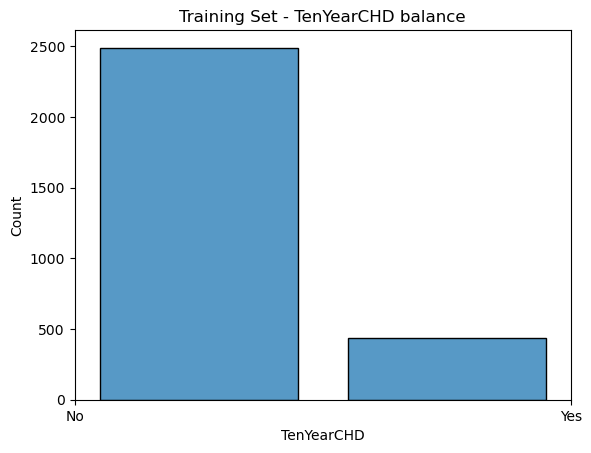

In [28]:
sns.histplot(y_train, kde=False, bins=2, shrink=0.8)
plt.title('Training Set - TenYearCHD balance')
plt.xlabel('TenYearCHD')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

In [29]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Store the column/feature names
feature_names = X_train.columns

# Convert the data to numpy arrays
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values.flatten()
y_test = y_test.values.flatten()

In [30]:
(y_train == 1).sum() / len(y_train), (y_test == 1).sum() / len(y_test)

(0.5, 0.16666666666666666)

/opt/anaconda3/envs/conda311/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


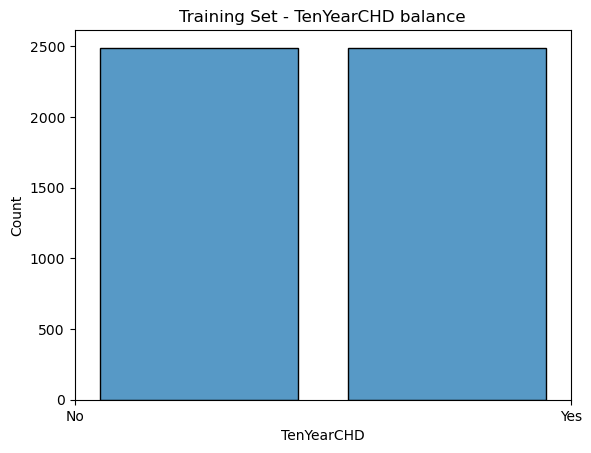

In [31]:
sns.histplot(y_train, kde=False, bins=2, shrink=0.8)
plt.title('Training Set - TenYearCHD balance')
plt.xlabel('TenYearCHD')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

In [32]:
# Create a dictionary to store the results
results = {}

Results for Logistic Regression SMOTE Model:
Training Accuracy: 0.7057
Testing Accuracy: 0.6639

Training Precision: 0.7022
Testing Precision: 0.2721

Training Recall: 0.7143
Testing Recall: 0.6066

Training F1 Score: 0.7082
Testing F1 Score: 0.3756

Training ROC AUC: 0.7057
Testing ROC AUC: 0.6410


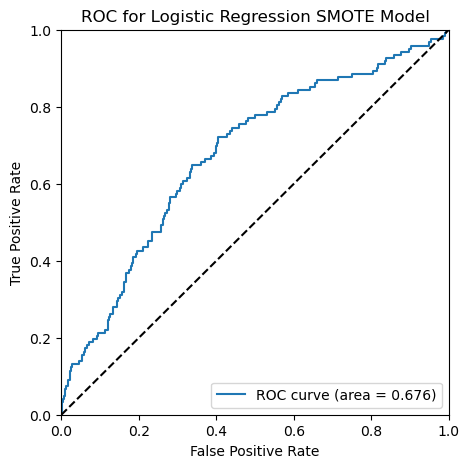

Classification Report for Logistic Regression SMOTE Model:
              precision    recall  f1-score   support

           0       0.90      0.68      0.77       610
           1       0.27      0.61      0.38       122

    accuracy                           0.66       732
   macro avg       0.58      0.64      0.57       732
weighted avg       0.79      0.66      0.70       732



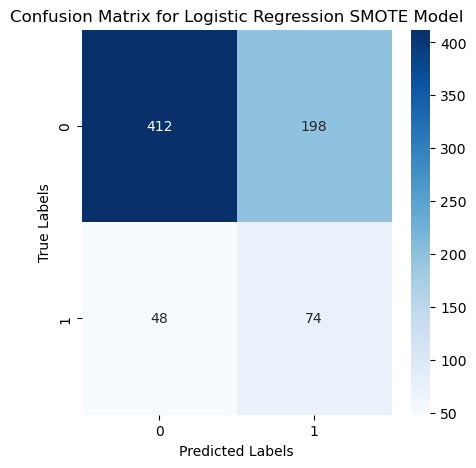

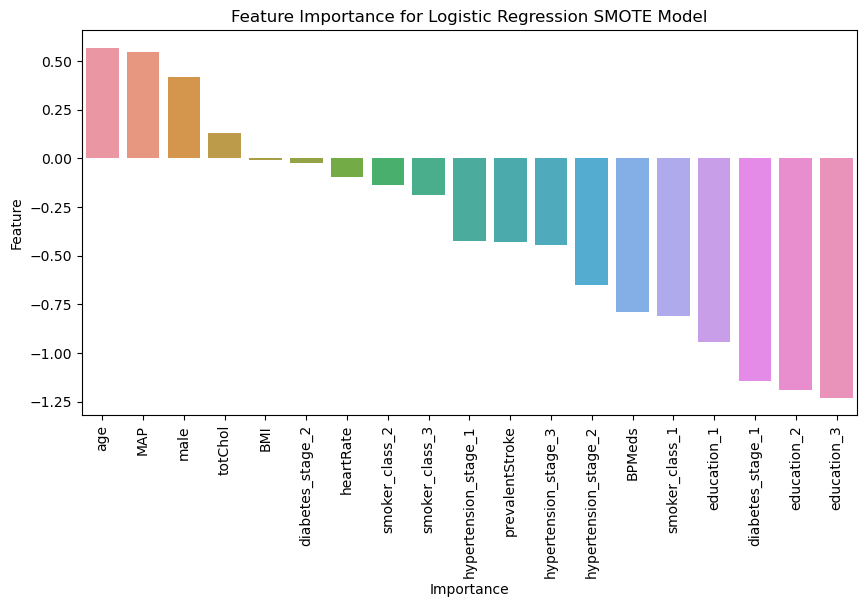

LogisticRegression()

In [33]:
# Logistic Regression
log_reg = LogisticRegression()

# Fit and evaluate the model
evaluate_model(log_reg, X_train, X_test, y_train, y_test, 'Logistic Regression SMOTE')

Results for K-Nearest Neighbors SMOTE Model:
Training Accuracy: 0.8628
Testing Accuracy: 0.6175

Training Precision: 0.7949
Testing Precision: 0.2138

Training Recall: 0.9779
Testing Recall: 0.4836

Training F1 Score: 0.8770
Testing F1 Score: 0.2965

Training ROC AUC: 0.8628
Testing ROC AUC: 0.5639


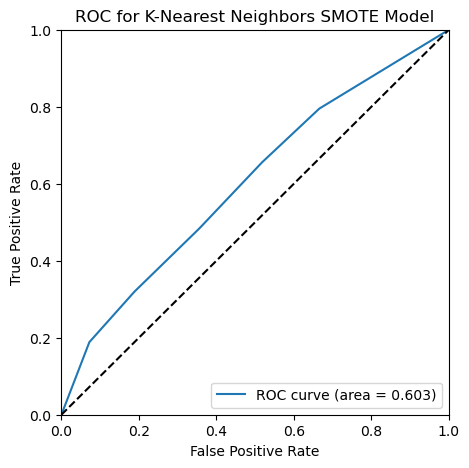

Classification Report for K-Nearest Neighbors SMOTE Model:
              precision    recall  f1-score   support

           0       0.86      0.64      0.74       610
           1       0.21      0.48      0.30       122

    accuracy                           0.62       732
   macro avg       0.54      0.56      0.52       732
weighted avg       0.75      0.62      0.66       732



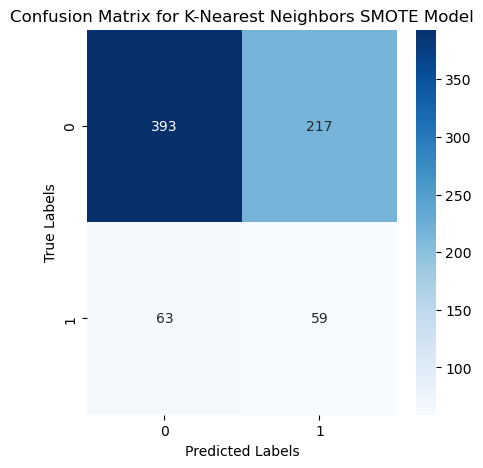

KNeighborsClassifier()

In [34]:
# K-Nearest Neighbors
knn = KNeighborsClassifier()

# Fit and evaluate the model
evaluate_model(knn, X_train, X_test, y_train, y_test, 'K-Nearest Neighbors SMOTE')

Results for Support Vector Machine SMOTE Model:
Training Accuracy: 0.8021
Testing Accuracy: 0.6612

Training Precision: 0.7749
Testing Precision: 0.2353

Training Recall: 0.8517
Testing Recall: 0.4590

Training F1 Score: 0.8115
Testing F1 Score: 0.3111

Training ROC AUC: 0.8021
Testing ROC AUC: 0.5803


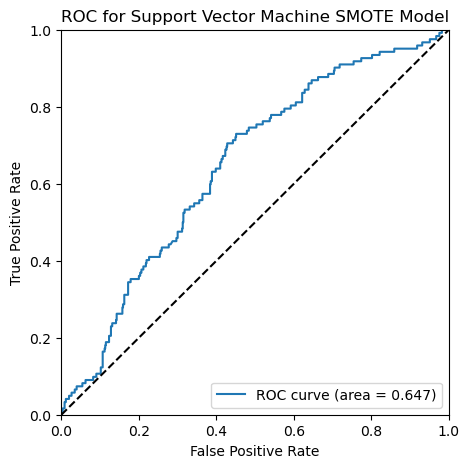

Classification Report for Support Vector Machine SMOTE Model:
              precision    recall  f1-score   support

           0       0.87      0.70      0.78       610
           1       0.24      0.46      0.31       122

    accuracy                           0.66       732
   macro avg       0.55      0.58      0.54       732
weighted avg       0.76      0.66      0.70       732



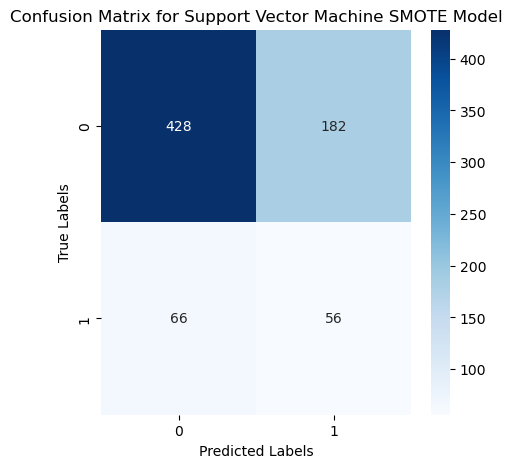

SVC(probability=True)

In [35]:
# Support Vector Machine
svm = SVC(probability=True)

# Fit and evaluate the model
evaluate_model(svm, X_train, X_test, y_train, y_test, 'Support Vector Machine SMOTE')

Results for Random Forest SMOTE Model:
Training Accuracy: 1.0000
Testing Accuracy: 0.7746

Training Precision: 1.0000
Testing Precision: 0.3130

Training Recall: 1.0000
Testing Recall: 0.2951

Training F1 Score: 1.0000
Testing F1 Score: 0.3038

Training ROC AUC: 1.0000
Testing ROC AUC: 0.5828


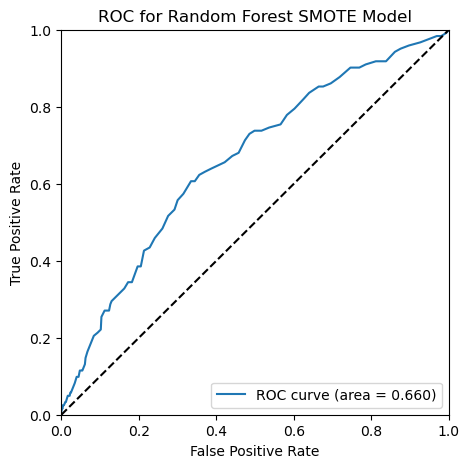

Classification Report for Random Forest SMOTE Model:
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       610
           1       0.31      0.30      0.30       122

    accuracy                           0.77       732
   macro avg       0.59      0.58      0.58       732
weighted avg       0.77      0.77      0.77       732



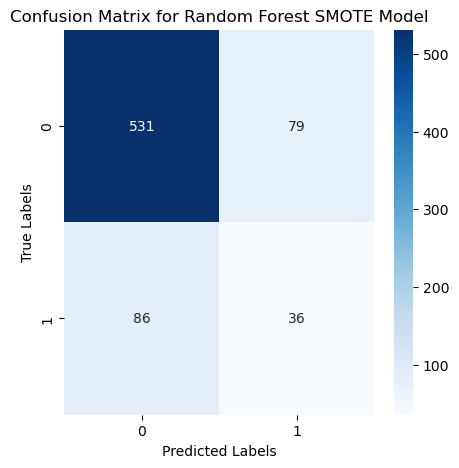

RandomForestClassifier()

In [36]:
# Random Forest
rf = RandomForestClassifier()

# Fit and evaluate the model
evaluate_model(rf, X_train, X_test, y_train, y_test, 'Random Forest SMOTE')

Results for Gradient Boosting SMOTE Model:
Training Accuracy: 0.8371
Testing Accuracy: 0.7322

Training Precision: 0.8217
Testing Precision: 0.3131

Training Recall: 0.8610
Testing Recall: 0.5082

Training F1 Score: 0.8409
Testing F1 Score: 0.3875

Training ROC AUC: 0.8371
Testing ROC AUC: 0.6426


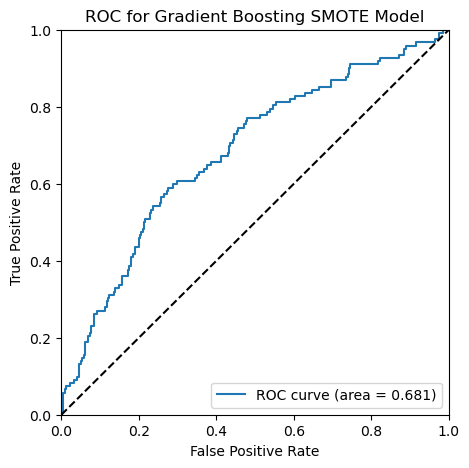

Classification Report for Gradient Boosting SMOTE Model:
              precision    recall  f1-score   support

           0       0.89      0.78      0.83       610
           1       0.31      0.51      0.39       122

    accuracy                           0.73       732
   macro avg       0.60      0.64      0.61       732
weighted avg       0.79      0.73      0.76       732



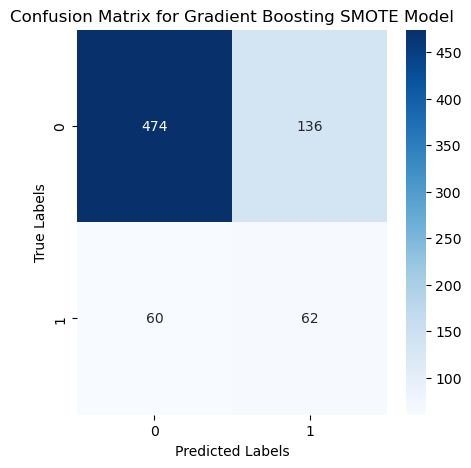

GradientBoostingClassifier()

In [37]:
# Gradient Boosting
gb = GradientBoostingClassifier()

# Fit and evaluate the model
evaluate_model(gb, X_train, X_test, y_train, y_test, 'Gradient Boosting SMOTE')

Results for XGBoost SMOTE Model:
Training Accuracy: 0.9904
Testing Accuracy: 0.8019

Training Precision: 0.9992
Testing Precision: 0.3333

Training Recall: 0.9815
Testing Recall: 0.1885

Training F1 Score: 0.9903
Testing F1 Score: 0.2408

Training ROC AUC: 0.9904
Testing ROC AUC: 0.5566


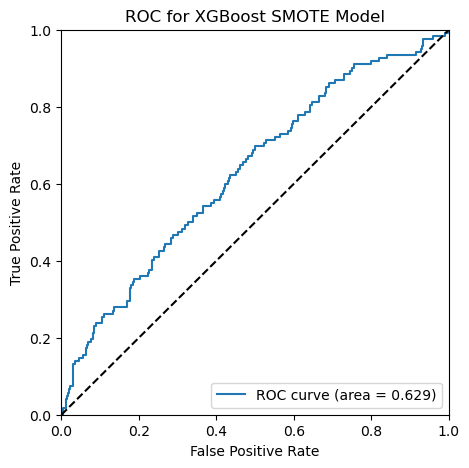

Classification Report for XGBoost SMOTE Model:
              precision    recall  f1-score   support

           0       0.85      0.92      0.89       610
           1       0.33      0.19      0.24       122

    accuracy                           0.80       732
   macro avg       0.59      0.56      0.56       732
weighted avg       0.76      0.80      0.78       732



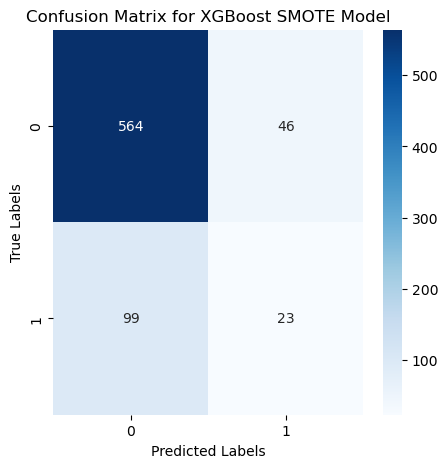

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [38]:
# XGBoost
xgb = XGBClassifier()

# Fit and evaluate the model
evaluate_model(xgb, X_train, X_test, y_train, y_test, 'XGBoost SMOTE')

In [39]:
# View the results
results_df_smote = pd.DataFrame(results).T
results_df_smote

,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1 Score,Test F1 Score,Train ROC AUC,Test ROC AUC,Model
Logistic Regression SMOTE,0.705705,0.663934,0.702212,0.272059,0.714343,0.606557,0.708225,0.375635,0.705705,0.640984,LogisticRegression()
K-Nearest Neighbors SMOTE,0.862796,0.617486,0.794905,0.213768,0.977903,0.483607,0.876959,0.296482,0.862796,0.563934,KNeighborsClassifier()
Support Vector Machine SMOTE,0.802129,0.661202,0.774854,0.235294,0.851748,0.459016,0.811483,0.311111,0.802129,0.580328,SVC(probability=True)
Random Forest SMOTE,1.0,0.77459,1.0,0.313043,1.0,0.295082,1.0,0.303797,1.0,0.582787,"(DecisionTreeClassifier(max_features='sqrt', r..."
Gradient Boosting SMOTE,0.837083,0.73224,0.821702,0.313131,0.860988,0.508197,0.840887,0.3875,0.837083,0.642623,([DecisionTreeRegressor(criterion='friedman_ms...
XGBoost SMOTE,0.990358,0.801913,0.999182,0.333333,0.981519,0.188525,0.990272,0.240838,0.990358,0.556557,"XGBClassifier(base_score=None, booster=None, c..."


In [40]:
# Append the results to the original results
results_all = pd.concat([results_df, results_df_smote])
score_cols = ['Train Accuracy', 'Test Accuracy', 'Train Precision', 'Test Precision', 'Train Recall', 'Test Recall', 'Train F1 Score', 'Test F1 Score', 'Train ROC AUC', 'Test ROC AUC']

results_all_scores = results_all[score_cols]

# Color the cells in the table based on the values in the cells using a gradient colormap (plasma)
results_all_scores = results_all_scores.style.background_gradient(cmap='plasma', axis=None, vmin=0, vmax=1, subset=pd.IndexSlice[:, :])

results_all_scores

,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1 Score,Test F1 Score,Train ROC AUC,Test ROC AUC
Logistic Regression,0.855335,0.834699,0.607143,0.533333,0.078161,0.065574,0.138493,0.116788,0.534661,0.527049
Naive Bayes,0.817031,0.792350,0.355491,0.352941,0.282759,0.295082,0.314981,0.321429,0.596582,0.593443
K-Nearest Neighbors Best Params,1.000000,0.771858,1.000000,0.281553,1.000000,0.237705,1.000000,0.257778,1.000000,0.558197
K-Nearest Neighbors,0.869357,0.830601,0.726496,0.464286,0.195402,0.106557,0.307971,0.173333,0.591273,0.540984
SVM Best Params,0.939466,0.796448,0.992366,0.309859,0.597701,0.180328,0.746055,0.227979,0.798449,0.550000
Support Vector Machine,0.854651,0.833333,0.857143,0.500000,0.027586,0.008197,0.053452,0.016129,0.513391,0.503279
Random Forest,1.000000,0.831967,1.000000,0.454545,1.000000,0.040984,1.000000,0.075188,1.000000,0.515574
Random Forest Best Params,1.000000,0.823770,1.000000,0.315789,1.000000,0.049180,1.000000,0.085106,1.000000,0.513934
Gradient Boosting,0.883379,0.831967,0.989583,0.473684,0.218391,0.073770,0.357815,0.127660,0.608995,0.528689
XGBoost,0.990082,0.812842,1.000000,0.317073,0.933333,0.106557,0.965517,0.159509,0.966667,0.530328


Trying some of the models (Logistic Regression and Gradient Boosting) on data with dropped missing values with SMOTE applied.

In [41]:
# Load data
df_drop = pd.read_csv("../data/processed/data_drop_processed.csv")

X_drop = df_drop.drop('TenYearCHD', axis=1)
y_drop = df_drop['TenYearCHD']

# Split the data into training and testing sets
X_train_drop, X_test_drop, y_train_drop, y_test_drop = train_test_split(X_drop, y_drop, test_size=0.2, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_drop, y_train_drop = smote.fit_resample(X_train_drop, y_train_drop)

# Store the column/feature names
feature_names = X_train_drop.columns

# Convert the data to numpy arrays
X_train_drop = X_train_drop.values
X_test_drop = X_test_drop.values
y_train_drop = y_train_drop.values.flatten()
y_test_drop = y_test_drop.values.flatten()

Results for Logistic Regression SMOTE Drop Model:
Training Accuracy: 0.7057
Testing Accuracy: 0.6639

Training Precision: 0.7022
Testing Precision: 0.2721

Training Recall: 0.7143
Testing Recall: 0.6066

Training F1 Score: 0.7082
Testing F1 Score: 0.3756

Training ROC AUC: 0.7057
Testing ROC AUC: 0.6410


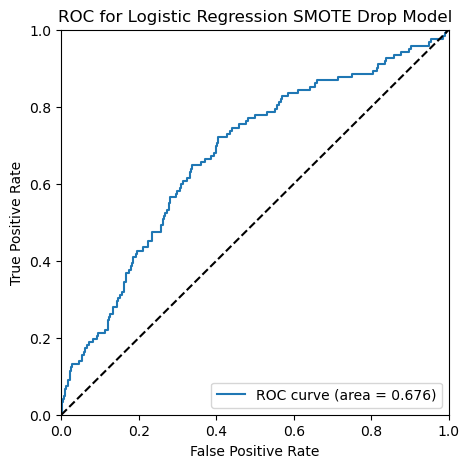

Classification Report for Logistic Regression SMOTE Drop Model:
              precision    recall  f1-score   support

           0       0.90      0.68      0.77       610
           1       0.27      0.61      0.38       122

    accuracy                           0.66       732
   macro avg       0.58      0.64      0.57       732
weighted avg       0.79      0.66      0.70       732



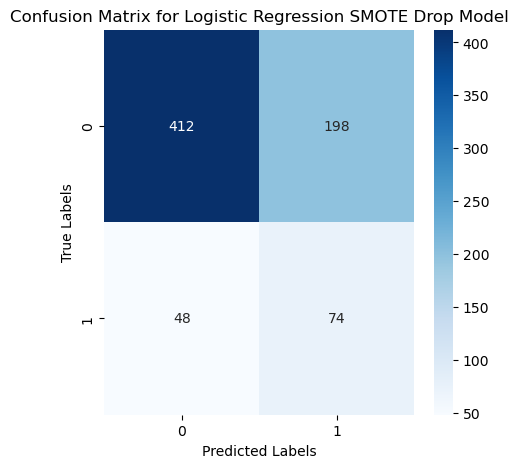

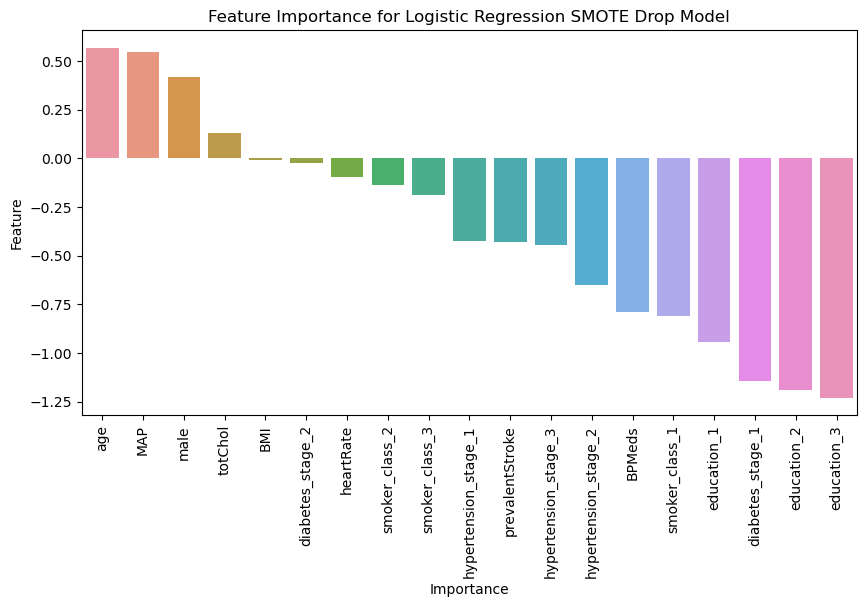

LogisticRegression()

In [42]:
# Logistic Regression
log_reg = LogisticRegression()

# Fit and evaluate the model
evaluate_model(log_reg, X_train_drop, X_test_drop, y_train_drop, y_test_drop, 'Logistic Regression SMOTE Drop')

Results for Gradient Boosting SMOTE Drop Model:
Training Accuracy: 0.8371
Testing Accuracy: 0.7322

Training Precision: 0.8217
Testing Precision: 0.3131

Training Recall: 0.8610
Testing Recall: 0.5082

Training F1 Score: 0.8409
Testing F1 Score: 0.3875

Training ROC AUC: 0.8371
Testing ROC AUC: 0.6426


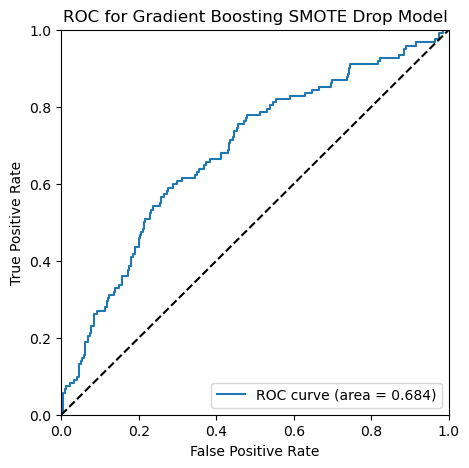

Classification Report for Gradient Boosting SMOTE Drop Model:
              precision    recall  f1-score   support

           0       0.89      0.78      0.83       610
           1       0.31      0.51      0.39       122

    accuracy                           0.73       732
   macro avg       0.60      0.64      0.61       732
weighted avg       0.79      0.73      0.76       732



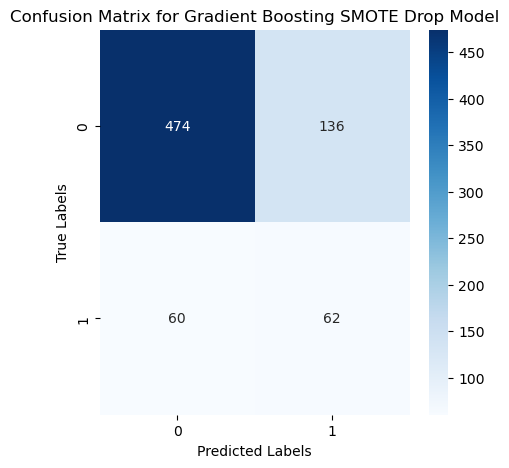

GradientBoostingClassifier()

In [43]:
# Gradient Boosting
gb = GradientBoostingClassifier()

# Fit and evaluate the model
evaluate_model(gb, X_train_drop, X_test_drop, y_train_drop, y_test_drop, 'Gradient Boosting SMOTE Drop')

In [44]:
# View the results table
results_df_drop = pd.DataFrame(results).T
results_all = pd.concat([results_all, results_df_drop])
results_all.drop_duplicates(inplace=True)

In [45]:

compare_drops = results_all.loc[['Logistic Regression SMOTE', 'Logistic Regression SMOTE Drop', 'Gradient Boosting SMOTE', 'Gradient Boosting SMOTE Drop']]
results_comp_scores = compare_drops[score_cols].style.background_gradient(cmap='plasma', axis=None, vmin=0, vmax=1, subset=pd.IndexSlice[:, :])
results_comp_scores

,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1 Score,Test F1 Score,Train ROC AUC,Test ROC AUC
Logistic Regression SMOTE,0.705705,0.663934,0.702212,0.272059,0.714343,0.606557,0.708225,0.375635,0.705705,0.640984
Logistic Regression SMOTE Drop,0.705705,0.663934,0.702212,0.272059,0.714343,0.606557,0.708225,0.375635,0.705705,0.640984
Gradient Boosting SMOTE,0.837083,0.732240,0.821702,0.313131,0.860988,0.508197,0.840887,0.387500,0.837083,0.642623
Gradient Boosting SMOTE Drop,0.837083,0.732240,0.821702,0.313131,0.860988,0.508197,0.840887,0.387500,0.837083,0.642623


Results for these two models applied on SMOTE-balanced dataset with missing values imputed or dropped are the same.

In [46]:
# Sort the results by the Test ROC AUC score
results_all.sort_values(by='Test ROC AUC', ascending=False, inplace=True)

results_all_colored = results_all[score_cols].style.background_gradient(cmap='plasma', axis=None, vmin=0, vmax=1, subset=pd.IndexSlice[:, :])
results_all_colored

,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1 Score,Test F1 Score,Train ROC AUC,Test ROC AUC
Gradient Boosting SMOTE Drop,0.837083,0.732240,0.821702,0.313131,0.860988,0.508197,0.840887,0.387500,0.837083,0.642623
Gradient Boosting SMOTE,0.837083,0.732240,0.821702,0.313131,0.860988,0.508197,0.840887,0.387500,0.837083,0.642623
Logistic Regression SMOTE Drop,0.705705,0.663934,0.702212,0.272059,0.714343,0.606557,0.708225,0.375635,0.705705,0.640984
Logistic Regression SMOTE,0.705705,0.663934,0.702212,0.272059,0.714343,0.606557,0.708225,0.375635,0.705705,0.640984
Naive Bayes,0.817031,0.792350,0.355491,0.352941,0.282759,0.295082,0.314981,0.321429,0.596582,0.593443
Random Forest SMOTE,1.000000,0.774590,1.000000,0.313043,1.000000,0.295082,1.000000,0.303797,1.000000,0.582787
Support Vector Machine SMOTE,0.802129,0.661202,0.774854,0.235294,0.851748,0.459016,0.811483,0.311111,0.802129,0.580328
K-Nearest Neighbors SMOTE,0.862796,0.617486,0.794905,0.213768,0.977903,0.483607,0.876959,0.296482,0.862796,0.563934
K-Nearest Neighbors Best Params,1.000000,0.771858,1.000000,0.281553,1.000000,0.237705,1.000000,0.257778,1.000000,0.558197
XGBoost SMOTE,0.990358,0.801913,0.999182,0.333333,0.981519,0.188525,0.990272,0.240838,0.990358,0.556557


## Results
Based on the evaluation of models' ROC AUC score, the best model is the Gradient Boost model applied over the SMOTE-balanced dataset. But...

Here we are trying to solve the Public Health issue. In this case what we really need is a good screening test, which will:
- minimize `FN` (False Negatives)
- maximize `TP` (True Positives)

We may just pick the model with the lowest `FN` and the highest `TP` or just with the highest Test Recall: 
$$Recall=\frac{TP}{TP+FN}$$



In [47]:
# Sort results by the Test Recall score
results_all.sort_values(by='Test Recall', ascending=False, inplace=True)

results_all_colored = results_all[score_cols].style.background_gradient(cmap='plasma', axis=None, vmin=0, vmax=1, subset=pd.IndexSlice[:, :])
results_all_colored

,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1 Score,Test F1 Score,Train ROC AUC,Test ROC AUC
Logistic Regression SMOTE Drop,0.705705,0.663934,0.702212,0.272059,0.714343,0.606557,0.708225,0.375635,0.705705,0.640984
Logistic Regression SMOTE,0.705705,0.663934,0.702212,0.272059,0.714343,0.606557,0.708225,0.375635,0.705705,0.640984
Gradient Boosting SMOTE Drop,0.837083,0.732240,0.821702,0.313131,0.860988,0.508197,0.840887,0.387500,0.837083,0.642623
Gradient Boosting SMOTE,0.837083,0.732240,0.821702,0.313131,0.860988,0.508197,0.840887,0.387500,0.837083,0.642623
K-Nearest Neighbors SMOTE,0.862796,0.617486,0.794905,0.213768,0.977903,0.483607,0.876959,0.296482,0.862796,0.563934
Support Vector Machine SMOTE,0.802129,0.661202,0.774854,0.235294,0.851748,0.459016,0.811483,0.311111,0.802129,0.580328
Naive Bayes,0.817031,0.792350,0.355491,0.352941,0.282759,0.295082,0.314981,0.321429,0.596582,0.593443
Random Forest SMOTE,1.000000,0.774590,1.000000,0.313043,1.000000,0.295082,1.000000,0.303797,1.000000,0.582787
K-Nearest Neighbors Best Params,1.000000,0.771858,1.000000,0.281553,1.000000,0.237705,1.000000,0.257778,1.000000,0.558197
XGBoost SMOTE,0.990358,0.801913,0.999182,0.333333,0.981519,0.188525,0.990272,0.240838,0.990358,0.556557


According to the table of performances, the Logistic Regression model with Balanced Train Set has the highest Train Recall value. Thus, this model best suits our goal. Let's view the confusion matrix for this model and second best model once again.

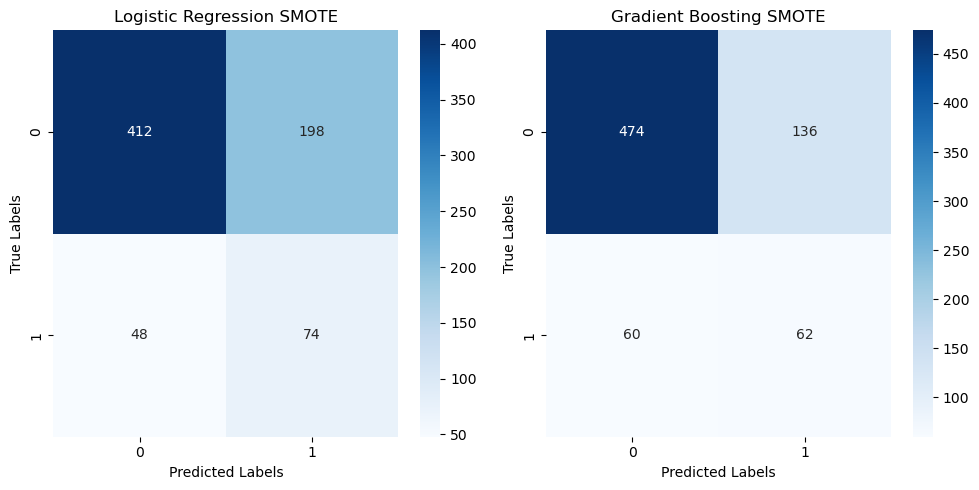

In [50]:
best_model = results['Logistic Regression SMOTE']['Model']
second_best_model = results['Gradient Boosting SMOTE']['Model']

# Show two confusion matrices side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Confusion matrix for Logistic Regression SMOTE
y_test_pred = best_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax[0])

# Confusion matrix for Gradient Boosting SMOTE
y_test_pred = second_best_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax[1])

ax[0].set_title('Logistic Regression SMOTE')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')

ax[1].set_title('Gradient Boosting SMOTE')
ax[1].set_xlabel('Predicted Labels')
ax[1].set_ylabel('True Labels')

plt.tight_layout()
plt.show()

We can see that in the test set, the model successfully identified 74 out of 122 patients with the Positive Ten Year CHD Risk. Whereas the second best model identified only a half of these patients.

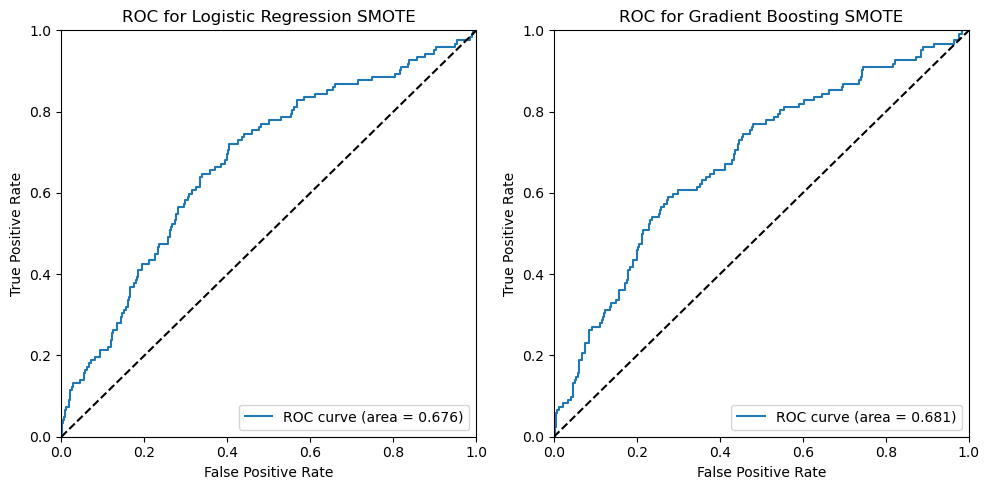

In [53]:
# View the ROC curves for the best and second best models side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# ROC curve for Logistic Regression SMOTE
fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
ax[0].plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
ax[0].plot([0, 1], [0, 1], 'k--')
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.0])
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('ROC for Logistic Regression SMOTE')
ax[0].legend(loc="lower right")

# ROC curve for Gradient Boosting SMOTE
fpr, tpr, thresholds = roc_curve(y_test, second_best_model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
ax[1].plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
ax[1].plot([0, 1], [0, 1], 'k--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.0])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('ROC for Gradient Boosting SMOTE')
ax[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

ROC curves for these two models look almost the same with the area under the curve ~0.68 for both of the models.

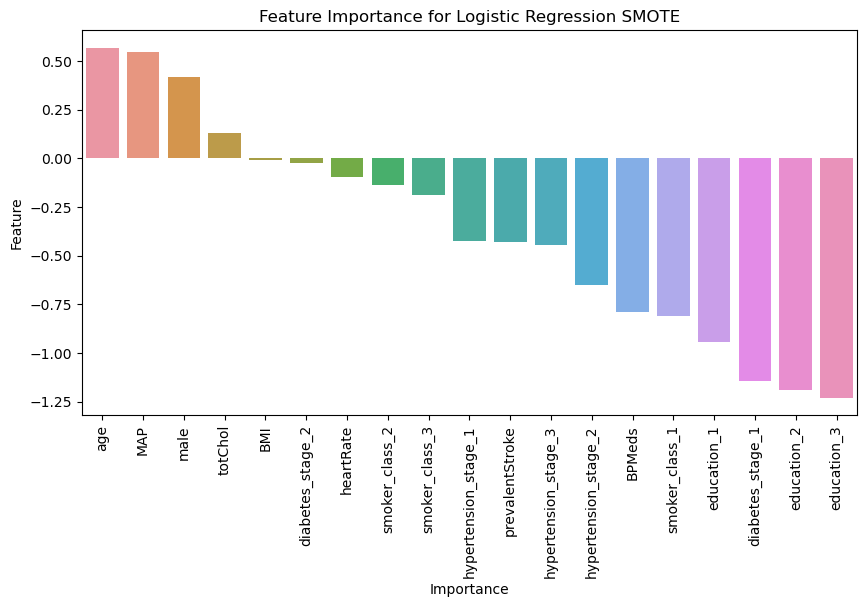

In [54]:
# View the feature importance for the best model
feature_importances = best_model.coef_
feature_imp_df = pd.DataFrame(feature_importances)
feature_imp_df.columns = feature_names
feature_imp_df = feature_imp_df.T
feature_imp_df.columns = ['Importance']
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)
feature_imp_df = feature_imp_df.T

plt.figure(figsize=(10, 5))
sns.barplot(feature_imp_df)
plt.xticks(rotation=90)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Logistic Regression SMOTE')
plt.show()

The most important features (as predicted during EDA) are:
- Patient's age
- Mean Arterial Pressure
- Being Male
- (honorable mention for the Blood Cholesterol Concentration)

Hyperparameter tuning for Logistic Regression Model

In [57]:
# Hyperparameter tuning for Logistic Regression
param_grid = {'C': np.logspace(-4, 4, 20),
              'penalty': ['l1', 'l2', 'elasticnet', 'None'],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'max_iter': [100, 200, 300, 400, 500]}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
scorer = make_scorer(recall_score, average='binary')

log_reg = LogisticRegression()
log_reg_grid = GridSearchCV(log_reg, param_grid, scoring=scorer, cv=cv, n_jobs=-1)

# Fit and evaluate the model
log_reg_grid.fit(X_train, y_train)

# Print the results
print(f"Best params:\n{log_reg_grid.best_params_}\n")
print(f"Best score:\n{log_reg_grid.best_score_}\n")

/opt/anaconda3/envs/conda311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/conda311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/conda311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/conda311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/conda311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/conda311/lib/py

Best params:
{'C': 0.004832930238571752, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}

Best score:
0.7393803247867392



/opt/anaconda3/envs/conda311/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
19500 fits failed out of a total of 30000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1500 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/conda311/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/conda311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3

Results for Logistic Regression Best Params Model:
Training Accuracy: 0.6541
Testing Accuracy: 0.5738

Training Precision: 0.6323
Testing Precision: 0.2390

Training Recall: 0.7364
Testing Recall: 0.7131

Training F1 Score: 0.6804
Testing F1 Score: 0.3580

Training ROC AUC: 0.6541
Testing ROC AUC: 0.6295


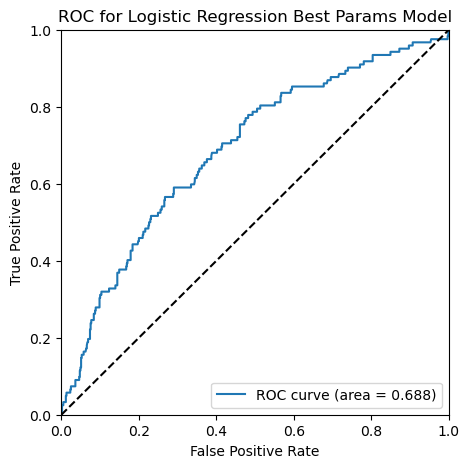

Classification Report for Logistic Regression Best Params Model:
              precision    recall  f1-score   support

           0       0.90      0.55      0.68       610
           1       0.24      0.71      0.36       122

    accuracy                           0.57       732
   macro avg       0.57      0.63      0.52       732
weighted avg       0.79      0.57      0.63       732



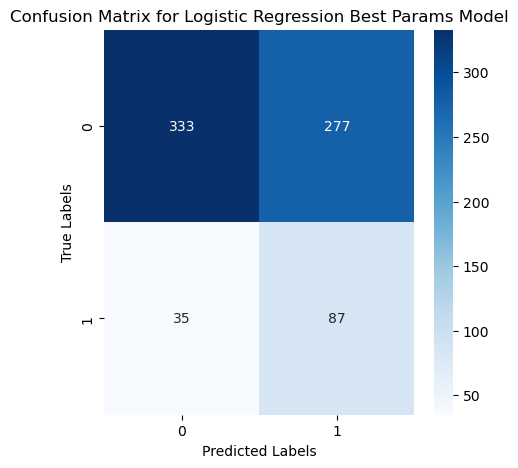

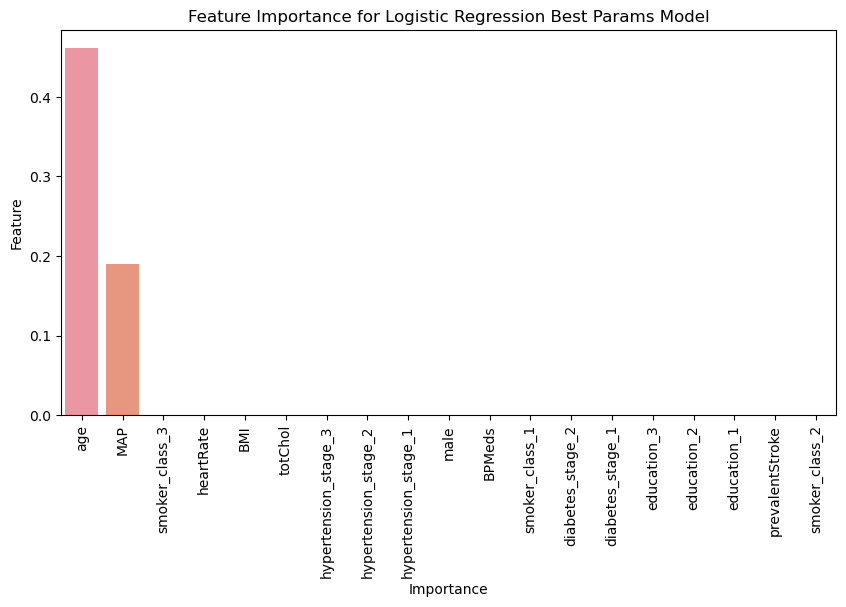

LogisticRegression(C=0.004832930238571752, penalty='l1', solver='liblinear')

In [61]:
# Fit and evaluate the model with the best parameters
best_C = log_reg_grid.best_params_['C']
best_max_iter = log_reg_grid.best_params_['max_iter']
best_penalty = log_reg_grid.best_params_['penalty']
best_solver = log_reg_grid.best_params_['solver']

log_reg = LogisticRegression(C=best_C, max_iter=best_max_iter, penalty=best_penalty, solver=best_solver)

# Fit and evaluate the model
evaluate_model(log_reg, X_train, X_test, y_train, y_test, 'Logistic Regression Best Params', grid_search=False)


In [63]:
results_df = pd.DataFrame(results).T
results_all = pd.concat([results_all, results_df])

In [69]:
results_all.drop_duplicates(inplace=True)
results_all.sort_values(by=['Test Recall'], ascending=False, inplace=True)
results_all.head()

,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1 Score,Test F1 Score,Train ROC AUC,Test ROC AUC,Model
Logistic Regression Best Params,0.654078,0.57377,0.632287,0.239011,0.73644,0.713115,0.680401,0.358025,0.654078,0.629508,"LogisticRegression(C=0.004832930238571752, pen..."
Logistic Regression SMOTE,0.705705,0.663934,0.702212,0.272059,0.714343,0.606557,0.708225,0.375635,0.705705,0.640984,LogisticRegression()
Logistic Regression SMOTE Drop,0.705705,0.663934,0.702212,0.272059,0.714343,0.606557,0.708225,0.375635,0.705705,0.640984,LogisticRegression()
Gradient Boosting SMOTE,0.837083,0.73224,0.821702,0.313131,0.860988,0.508197,0.840887,0.3875,0.837083,0.642623,([DecisionTreeRegressor(criterion='friedman_ms...
Gradient Boosting SMOTE Drop,0.837083,0.73224,0.821702,0.313131,0.860988,0.508197,0.840887,0.3875,0.837083,0.642623,([DecisionTreeRegressor(criterion='friedman_ms...


In [70]:
best_model_params = results['Logistic Regression Best Params']['Model']

# Save the model to disk
import joblib

# joblib.dump(best_model_params, '../models/logistic_regression_model.pkl')

['../models/logistic_regression_model.pkl']